* load wfstore
* load annots Store
* choose chunker
* choose featurizer
* choose train/test split: mark sessions as train or test


# Using pipeline maker

In [1]:
import os
import soundfile as sf
import pandas as pd
import zipfile
from io import BytesIO
from pathlib import Path

from dol.appendable import add_append_functionality_to_store_cls
from dol import Store
from dol import FilesOfZip, wrap_kvs, filt_iter

from py2store import FilesOfZip
from hear import WavLocalFileStore
from dol import FuncReader



def my_obj_of_data(b):
    return sf.read(BytesIO(b), dtype="float32")[0]

@wrap_kvs(obj_of_data=my_obj_of_data)
@filt_iter(filt=lambda x: not x.startswith("__MACOSX") and x.endswith(".wav"))
class WfZipStore(FilesOfZip):
    """Waveform access. Keys are .wav filenames and values are numpy arrays of int16 waveform."""

    pass


def key_to_ext(k):
    _, ext = os.path.splitext(k)
    if ext.startswith("."):
        ext = ext[1:]
    return ext


def processor_from_ext(ext):
    if ext.startswith("."):
        ext = ext[1:]
    if ext in {"zip"}:
        pass
    elif ext in {"wav"}:
        pass

def is_zip_file(filepath):
    return zipfile.is_zipfile(filepath)

def is_dir(filepath):
    return os.path.isdir(filepath)

def key_maker(name, prefix):
    return f'{prefix}_{name}'

def wf_store_factory(filepath):
    key = key_maker(name = filepath, prefix='wf_store')
    tag = 'wf_store'

    if is_dir(filepath):
        data = WavLocalFileStore(filepath)

         
    elif is_zip_file(filepath):
        data = WfZipStore(filepath)

    return mk_store_item(key, tag, data)

def annot_store_factory(filepath):
    key = key_maker(name = filepath, prefix='annot_store')
    tag = 'annot_store'

    data = pd.read_csv(filepath)

    return mk_store_item(key, tag, data)

def mk_store_item(key, tag, data):
    return dict(key = key, tag = tag, data=data)

def append_to_store(store, item):
    store.append(item)

def dacc_factory():
    pass

factory_store = {'wf_factory': wf_store_factory, 'dacc':None, 'annot_factory':annot_store_factory}

#factory_store = FuncReader([wf_store_factory, dacc_factory])

store_cls = Store
item2kv = lambda item: (item['key'], item['data'])

appendable_store_cls = add_append_functionality_to_store_cls(store_cls, item2kv=item2kv)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# example
rootdir = '/Users/sylvain/Dropbox/Otosense/VacuumEdgeImpulse/'
annot_filepath = '/Users/sylvain/Dropbox/sipyb/Testing/data/annots_vacuum.csv'
#is_dir(rootdir)

In [3]:
# mock functions
def mk_global_store():
    return appendable_store_cls()

def select_wf_factory():
    return {'key':'wf_store_factory', 'data':wf_store_factory}

def select_annot_factory():
    return {'key':'annot_store_factory', 'data':annot_store_factory}

In [4]:
# user story: make a global store and add a wfstore to it

global_store = mk_global_store()
wf_factory = select_wf_factory()
global_store.append(wf_factory)
annot_factory = select_annot_factory()
global_store.append(annot_factory)


In [5]:
global_store

{'wf_store_factory': <function wf_store_factory at 0x7f897cc96b80>, 'annot_store_factory': <function annot_store_factory at 0x7f897cc96c10>}

# Without using pipeline maker

* load wfstore
* load annots Store
* choose chunker
* choose featurizer
* choose model
* train model


In [6]:
d = dict(key = 'example')

In [7]:
d()

TypeError: 'dict' object is not callable

# Scrap

In [ ]:
from meshed import dag
from dol import filt_iter, wrap_kvs, Files, Pipe
import recode

P = Pipe(
    Files,
    filt_iter(filt = lambda x: x.endswith('.wav')),
    wrap_kvs(obj_of_data=recode.decode_wav_bytes)

)

In [ ]:
p = P(rootdir)
list(p)

NameError: name 'rootdir' is not defined

In [ ]:
wf, sr = p['train/noise.DKITCHEN.24.3840000-4000000.wav.23q8e43a.ingestion-6bc8b65f8c-86d4w.wav']

NameError: name 'p' is not defined

In [ ]:
from hum import disp_wf

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [ ]:
disp_wf(wf)

NameError: name 'wf' is not defined

In [ ]:
list(Files(rootdir))

NameError: name 'rootdir' is not defined

# Make a dag and insert funcs

## Make a mall of factories

In [16]:
# step 1: make a mall of choices
from plunk.sb.front_experiments.streamlitfront_dataprep.data_prep2 import (
    data_from_wav_folder,
    data_from_csv,
    store_to_key_fvs,
    key_fvs_to_tag_fvs,
    mk_Xy
)
from odat.mdat.vacuum import (
    DFLT_ANNOTS_COLS,
    DFLT_CHUNKER,
    DFLT_FEATURIZER,
)

DFLT_CHUNKER_MAKER = lambda:DFLT_CHUNKER
DFLT_FEATURIZER_MAKER = lambda: DFLT_FEATURIZER


m = {'wf_store_maker':[data_from_wav_folder], 'annots_store_maker':[data_from_csv], 
    'chunker':[DFLT_CHUNKER_MAKER],
    'featurizer':[DFLT_FEATURIZER_MAKER]}

#might need to revert a dict if choices are given as a list
choices_list = [data_from_wav_folder, data_from_csv]

choices = {'wf_store_maker':data_from_wav_folder, 'annots_store_maker':data_from_csv, 
    'chunker_maker':DFLT_CHUNKER_MAKER,
    'featurizer_maker': DFLT_FEATURIZER_MAKER,
    'store_to_key_fvs':store_to_key_fvs,
    'key_fvs_to_tag_fvs':key_fvs_to_tag_fvs,
    'mk_Xy':mk_Xy}

In [24]:
# step 2: make a dag connecting these choices

from meshed import DAG, code_to_dag

def user_story():
    wf_store = wf_store_maker(wf_filepath) # explicit argument should not be here
    annots_df = annots_store_maker(annot_filepath) #explicit argument should not be here
    chunker = chunker_maker()
    featurizer = featurizer_maker()
    key_fvs = store_to_key_fvs(wf_store, chunker=chunker, featurizer=featurizer)
    tag_fv_iterator = key_fvs_to_tag_fvs(key_fvs, annots_df)
    X,y = mk_Xy(tag_fv_iterator)

In [ ]:
# Use funcnodes 

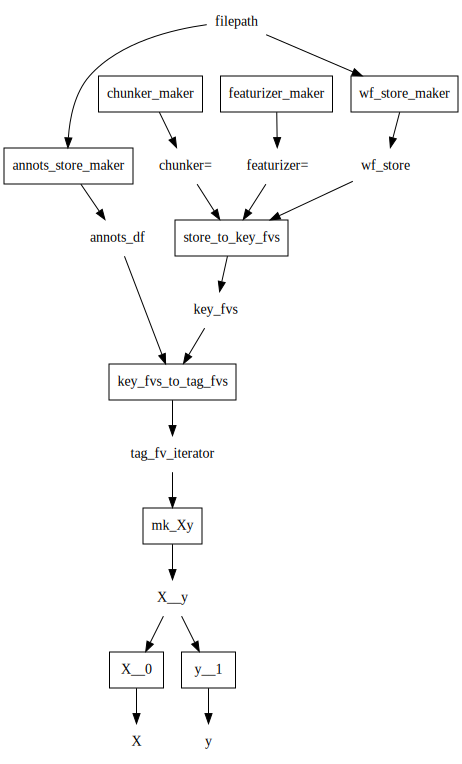

In [25]:
# If I remove the arguments wf_filepath and annot_filepath
# I hit the expected problem of same name for the arguments!
user_story =code_to_dag(user_story, func_src=choices)
user_story.dot_digraph()

In [19]:
# connect dag to inputs
from i2 import Sig
sig = Sig(user_story)
sig

<Sig (wf_filepath, annots_filepath)>

In [20]:
# example
wf_filepath = '/Users/sylvain/Dropbox/Otosense/VacuumEdgeImpulse/'
annots_filepath = '/Users/sylvain/Dropbox/sipyb/Testing/data/annots_vacuum.csv'

In [21]:
user_story(wf_filepath, annots_filepath)

(array([[  475.40582828, 10110.76729983, 10413.97642178, ...,
          1478.5182964 ,  3916.09114962,  6393.43290786],
        [  396.97587909, 10457.75990478,  8006.39004586, ...,
          3515.29222233,  3542.04477868,  2690.48838222],
        [ 5048.6254373 ,   664.65024889,  6110.731033  , ...,
          1484.09826686,  4337.05585912,  5050.61709907],
        ...,
        [  445.49515047,   641.50730682,  2288.75468089, ...,
          1942.87472535,  1123.95935225,   610.15506912],
        [  693.81790966,   663.09283702,   713.41995303, ...,
           186.07038774,   992.36327702,   917.8024724 ],
        [  132.51295741,   178.3712846 ,  1063.60388154, ...,
           542.19669309,   971.45828771,   895.11685255]]),
 ('vacuum',
  'vacuum',
  'vacuum',
  'vacuum',
  'vacuum',
  'vacuum',
  'vacuum',
  'vacuum',
  'vacuum',
  'vacuum',
  'vacuum',
  'vacuum',
  'vacuum',
  'vacuum',
  'vacuum',
  'vacuum',
  'vacuum',
  'vacuum',
  'vacuum',
  'vacuum',
  'vacuum',
  'vacuum',
 

In [ ]:
# make an app from the dag

# Create a DAG, one edge at a time

In [22]:
d= DAG()

In [23]:
d.add_edge()